# **Dependencies**

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
!pip uninstall transformer
!pip install git+https://github.com/huggingface/transformers
!pip install mamba-ssm[causal-conv1d]==2.2.4 --no-build-isolation
!pip install rouge-score

# **Data Preprocessing , DataSet and DataLoaders**

In [3]:
import os
import xml.etree.ElementTree as ET
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import GPT2Tokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torchvision import models
import math
from torch.cuda.amp import GradScaler, autocast
from transformers import get_cosine_schedule_with_warmup
from peft import get_peft_model, LoraConfig, TaskType
from tqdm import tqdm
import pandas as pd
import numpy as np
import gc
import re
from transformers import BitsAndBytesConfig
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup

2025-08-25 14:53:41.867953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756133622.085546      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756133622.146416      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


# **Configuration**

In [5]:
XML_REPORTS_PATH = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_reports/ecgen-radiology/"
IMAGES_PATH      = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/"

# Model & Training Params
TOKENIZER_NAME   = "gpt2"
BATCH_SIZE       = 8
MAX_SEQ_LENGTH   = 512
IMAGE_SIZE       = 224

# Data Split Params (R2Gen-style ratios commonly used in IU-Xray literature)
TRAIN_RATIO      = 0.80  # train
VALID_RATIO      = 0.10  # val
TEST_RATIO       = 0.10  # test
RANDOM_STATE     = 42
RAMDOM_SEED      = 9223
assert abs(TRAIN_RATIO + VALID_RATIO + TEST_RATIO - 1.0) < 1e-6, "Ratios must sum to 1."

In [6]:
# 2) Cleaning, patient-id extraction, manifest builder (multi-view + patient_id)

import re

_period_collapse = re.compile(r"\.{2,}")
# Keep periods and hyphens (for ranges, decimals)
_punct = re.compile(r'[,\?;*!%^&_+():\[\]{}"\\/]+')  

def clean_text(text):
    if not text:
        return ""

    # Remove placeholder, newlines, carriage returns
    text = text.replace('xxxx', '').replace('\n', ' ').replace('\r', ' ')

    # Collapse multiple periods to a single period
    text = _period_collapse.sub('.', text)

    # Lowercase and strip leading/trailing spaces
    text = text.strip().lower()

    # Split on periods but avoid empty strings
    sents = [s.strip() for s in text.split('.') if s.strip()]

    def sent_clean(s):
        # Remove unwanted punctuation
        s = _punct.sub('', s)
        # Collapse multiple spaces
        s = re.sub(r"\s+", " ", s)
        return s

    # Clean each sentence
    tokens = [sent_clean(s) for s in sents if sent_clean(s)]

    # Join sentences with " . " and add trailing period
    report = ' . '.join(tokens) + ' .'
    return report

def extract_patient_id_from_xml(xml_path):
    """
    Derive a stable patient_id for IU X-ray:
    - Prefer deriving from the first parentImage id 'CXR####_IM-...'
      -> returns 'PID_####'
    - Fallback to numeric digits in the XML filename stem.
    """
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        parent = root.find(".//parentImage")
        if parent is not None:
            pid_guess = parent.get('id') or ""
            m = re.search(r'CXR(\d+)', pid_guess)
            if m:
                return f"PID_{m.group(1)}"
    except Exception:
        pass
    stem = os.path.splitext(os.path.basename(xml_path))[0]
    m2 = re.search(r'(\d+)', stem)
    return f"PID_{m2.group(1) if m2 else stem}"

def create_data_manifest(xml_dir, img_dir, tokenizer=None, max_seq_length=512):
    """
    Build per-study multi-view manifest with patient_id.
    Returns list of dicts:
      {
        'patient_id': str,
        'image_paths': [list of .png paths for one study],
        'report_text': str   # clean concatenated findings + impression
      }
    """
    manifest = []
    xml_files = glob(os.path.join(xml_dir, "*.xml"))
    print(f"Scanning {len(xml_files)} XML files to create manifest...")

    for xml_file in tqdm(xml_files, desc="Scanning XMLs"):
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()

            impression_node = root.find(".//AbstractText[@Label='IMPRESSION']")
            findings_node   = root.find(".//AbstractText[@Label='FINDINGS']")
            impression_text = clean_text(impression_node.text if impression_node is not None else "")
            findings_text   = clean_text(findings_node.text   if findings_node   is not None else "")
            if not findings_text and not impression_text:
                continue

            full_report = f"<SECTION_FINDINGS> {findings_text} <SECTION_IMPRESSION> {impression_text} <|endoftext|>"
            image_nodes = root.findall(".//parentImage")
            seen = set()
            image_paths = []
            for node in image_nodes:
                image_filename = (node.get('id') or "") + ".png"
                if not image_filename or image_filename in seen:
                    continue
                seen.add(image_filename)
                image_path = os.path.join(img_dir, image_filename)
                if os.path.exists(image_path):
                    image_paths.append(image_path)
            if not image_paths:
                continue

            patient_id = extract_patient_id_from_xml(xml_file)

            manifest.append({
                'patient_id': patient_id,
                'image_paths': image_paths,
                'report_text': full_report
            })
        except Exception as e:
            print(f"Warning: Could not process {os.path.basename(xml_file)}. Error: {e}")
    return manifest


In [7]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class IUXRayDataset(Dataset):
    def __init__(self, manifest, tokenizer, image_transform=None, max_seq_length=512):
        self.manifest = manifest
        self.tokenizer = tokenizer
        self.image_transform = image_transform  # can be None
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        item = self.manifest[idx]
        report_text = item['report_text']
        image_paths = item['image_paths']  # list of view paths

        # Load and transform all views
        image_tensors = []
        for p in image_paths:
            image = Image.open(p).convert('RGB')
            if self.image_transform is not None:
                image_tensor = self.image_transform(image)
            else:
                # Default minimal transform: convert to tensor
                image_tensor = transforms.ToTensor()(image)
            image_tensors.append(image_tensor)

        # Tokenize the report text
        tokenized = self.tokenizer(
            report_text,
            padding="max_length",
            truncation=True,
            max_length=self.max_seq_length,
            return_tensors="pt",
            add_special_tokens=True,
        )

        input_ids = tokenized["input_ids"].squeeze(0)
        attention_mask = tokenized["attention_mask"].squeeze(0)
        labels = input_ids.clone()  # LM loss target
        labels[attention_mask == 0] = -100

        return {
            "images": image_tensors,       # list of (3,H,W)
            "input_ids": input_ids,        # torch tensor
            "attention_mask": attention_mask,
            "labels": labels,              # torch tensor
            "image_paths": image_paths,    # list[str]
            "patient_id": item.get("patient_id", None)
        }

In [8]:
from transformers import GPT2TokenizerFast

tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

# First add additional specials, then add pad token as [PAD]
tokenizer.add_special_tokens({"additional_special_tokens": ["<SECTION_FINDINGS>", "<SECTION_IMPRESSION>"]})
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"
# Sanity check (optional)
print("pad_token:", tokenizer.pad_token, "pad_token_id:", tokenizer.pad_token_id)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

pad_token: <|endoftext|> pad_token_id: 50256


In [9]:
def make_collate_fn(pad_token_id: int):
    def _collate(batch):
        if len(batch) == 0:
            raise ValueError("Empty batch received by collate_fn.")
        image_lists = [it['images'] for it in batch]
        image_paths_lists = [it['image_paths'] for it in batch]
        input_ids_list = [it['input_ids'] for it in batch]
        labels_list = [it['labels'] for it in batch]

        max_views = max(len(images) for images in image_lists)

        batch_images, mask = [], []
        for images in image_lists:
            if len(images) == 0:
                raise ValueError("Found a sample with zero images/views. Check your manifest.")
            last_image = images[-1]
            padded = images + [last_image] * (max_views - len(images))
            batch_images.append(torch.stack(padded))  # (V,3,H,W)
            mask.append([1] * len(images) + [0] * (max_views - len(images)))

        batch_images = torch.stack(batch_images)                # (B,V,3,H,W)
        view_mask   = torch.tensor(mask, dtype=torch.bool)      # (B,V)
        input_ids     = torch.stack([it['input_ids'] for it in batch])
        attention_mask= torch.stack([it['attention_mask'] for it in batch])
        labels        = torch.stack([it['labels'] for it in batch]).clone()  # (B,T)

        labels[attention_mask == 0] = -100

        return {
            'images': batch_images,
            'view_mask': view_mask,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels,
            'image_paths': image_paths_lists,
        }
    return _collate

collate_fn = make_collate_fn(tokenizer.pad_token_id)

# **Loaded Data Visualization**

In [10]:
# --- Reproducibility utilities ---
import os, random, numpy as np, torch

def set_global_seed(seed: int = 9223, deterministic: bool = True):
    # Python & NumPy
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # cuDNN / deterministic behavior
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:
        # Slightly faster but less reproducible
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True

    # Torch compile caches, dataloader reproducibility knobs (optional)
    os.environ.setdefault("CUBLAS_WORKSPACE_CONFIG", ":4096:8")  # for determinism on some ops
    # If using torch>=2.0, some ops may still be nondeterministic; see PyTorch docs.

# Call once, before any randomness-dependent code (tokenizer/dataloaders/models)
GLOBAL_SEED = 9223
set_global_seed(GLOBAL_SEED, deterministic=True)


In [11]:
def _worker_init_fn(worker_id):
    # Ensures each worker has a distinct, reproducible seed
    worker_seed = (GLOBAL_SEED + worker_id) % (2**32)
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(GLOBAL_SEED)


Scanning 3955 XML files to create manifest...


Scanning XMLs: 100%|██████████| 3955/3955 [00:32<00:00, 122.82it/s]

Total multi-view studies in manifest: 3826

Data successfully split (patient-level, multi-view, no leakage):
Unique patients total: 3826
Train patients: 3061, Val patients: 383, Test patients: 382
Training studies:   3061
Validation studies: 383
Test studies:       382

PyTorch DataLoaders are ready!

--- Verifying a sample batch from the train_loader ---


Batch keys: dict_keys(['images', 'view_mask', 'input_ids', 'attention_mask', 'labels', 'image_paths'])
Image tensor shape:      torch.Size([8, 3, 3, 224, 224])
View mask shape:         torch.Size([8, 3])
Input IDs tensor shape:  torch.Size([8, 512])
Attention mask shape:    torch.Size([8, 512])
Labels tensor shape:     torch.Size([8, 512])
First study image_paths: ['/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR31_IM-1450-1001.png', '/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR31_IM-1450-3003.png']


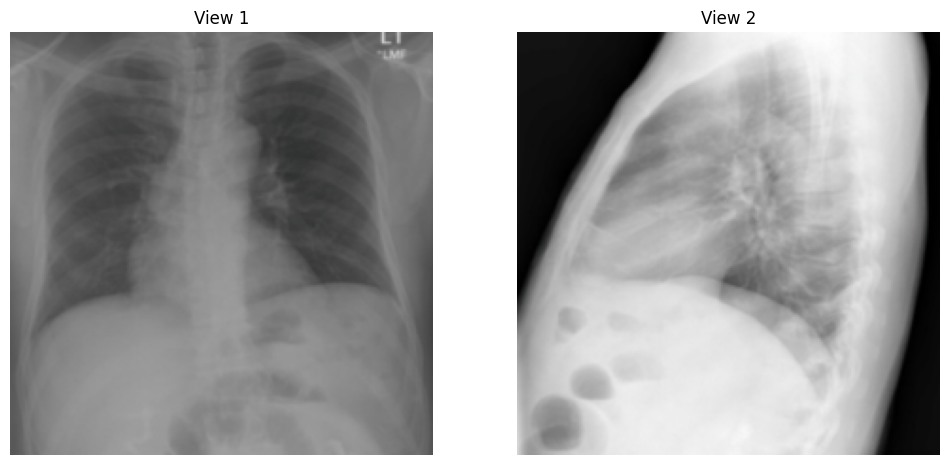


--- Sample Report (Decoded) ---
 lungs are clear without focal consolidation . no suspicious pulmonary nodules identified . no pleural effusions or pneumothoraces . heart and mediastinum of normal size and contour .  clear lungs . 
--------------------------------------------------


In [12]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms

# ImageNet normalization
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

# Train-time transforms (data augmentation)
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Val/Test-time transforms (deterministic)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),         # direct resize to 224x224 (no crop, deterministic)
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


# --- Create manifest for multi-view ---
# 5) Build manifest and patient-level split

full_manifest = create_data_manifest(
    XML_REPORTS_PATH,
    IMAGES_PATH,
    tokenizer,
    max_seq_length=MAX_SEQ_LENGTH
)
print(f"Total multi-view studies in manifest: {len(full_manifest)}")

# Unique patients and shuffled split
all_patients = sorted({m['patient_id'] for m in full_manifest})
random.Random(RANDOM_STATE).shuffle(all_patients)

n_patients = len(all_patients)
n_train = int(round(TRAIN_RATIO * n_patients))
n_val   = int(round(VALID_RATIO * n_patients))
n_test  = n_patients - n_train - n_val

train_patients = set(all_patients[:n_train])
val_patients   = set(all_patients[n_train:n_train+n_val])
test_patients  = set(all_patients[n_train+n_val:])

def filter_by_patients(manifest, keep_patients):
    return [m for m in manifest if m['patient_id'] in keep_patients]

train_manifest = filter_by_patients(full_manifest, train_patients)
val_manifest   = filter_by_patients(full_manifest, val_patients)
test_manifest  = filter_by_patients(full_manifest, test_patients)

print("\nData successfully split (patient-level, multi-view, no leakage):")
print(f"Unique patients total: {n_patients}")
print(f"Train patients: {len(train_patients)}, Val patients: {len(val_patients)}, Test patients: {len(test_patients)}")
print(f"Training studies:   {len(train_manifest)}")
print(f"Validation studies: {len(val_manifest)}")
print(f"Test studies:       {len(test_manifest)}")


# --- Create Datasets and DataLoaders for multi-view ---
# 6) Datasets and DataLoaders

train_dataset = IUXRayDataset(train_manifest, tokenizer, train_transform, max_seq_length=MAX_SEQ_LENGTH)
val_dataset   = IUXRayDataset(val_manifest,   tokenizer, val_transform, max_seq_length=MAX_SEQ_LENGTH)
test_dataset  = IUXRayDataset(test_manifest,  tokenizer, val_transform, max_seq_length=MAX_SEQ_LENGTH)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collate_fn,worker_init_fn=_worker_init_fn,
    generator=g,
    persistent_workers=True, pin_memory=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn,worker_init_fn=_worker_init_fn,
    generator=g,
    persistent_workers=True, pin_memory=True,
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn,worker_init_fn=_worker_init_fn,
    generator=g,
    persistent_workers=True, pin_memory=True,
)

print("\nPyTorch DataLoaders are ready!")

print("\n--- Verifying a sample batch from the train_loader ---")

# --- Fetch one batch
# 7) Quick sanity check: one batch + visualize views

sample_batch = next(iter(train_loader))
print(f"Batch keys: {sample_batch.keys()}")
print(f"Image tensor shape:      {sample_batch['images'].shape}")       # (B,V,3,H,W)
print(f"View mask shape:         {sample_batch['view_mask'].shape}")    # (B,V)
print(f"Input IDs tensor shape:  {sample_batch['input_ids'].shape}")    # (B,T)
print(f"Attention mask shape:    {sample_batch['attention_mask'].shape}")
print(f"Labels tensor shape:     {sample_batch['labels'].shape}")
print(f"First study image_paths: {sample_batch['image_paths'][0]}")

# Visualize all (non-padded) views for a random study in the batch
idx_to_show = random.randint(0, sample_batch['images'].size(0) - 1)
images_to_show = sample_batch['images'][idx_to_show]  # (V,3,H,W)
view_mask = sample_batch['view_mask'][idx_to_show]    # (V,)
num_views = images_to_show.size(0)

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

valid_indices = [i for i in range(num_views) if view_mask[i].item() == 1]
plt.figure(figsize=(6 * len(valid_indices), 6))
for plot_idx, i in enumerate(valid_indices, start=1):
    img_tensor = images_to_show[i]
    img_display = (img_tensor * std) + mean
    img_display = transforms.ToPILImage()(img_display.clamp(0, 1))
    plt.subplot(1, len(valid_indices), plot_idx)
    plt.imshow(img_display)
    plt.title(f"View {i+1}")
    plt.axis('off')
plt.show()

# Decode report for that study
input_ids_display = sample_batch['input_ids'][idx_to_show]
report_display = tokenizer.decode(input_ids_display, skip_special_tokens=True)
print("\n--- Sample Report (Decoded) ---")
print(report_display)
print("-" * 50)



In [13]:
# # === Sanity check: DataLoader ===
# sample_batch = next(iter(train_loader))

# print("\n--- Dataloader sanity check ---")
# print("Batch keys:", sample_batch.keys())
# print("Images:", sample_batch["images"].shape, sample_batch["images"].dtype)       # (B, V, 3, H, W)
# print("View mask:", sample_batch["view_mask"].shape, sample_batch["view_mask"].dtype) # (B, V)
# print("Input IDs:", sample_batch["input_ids"].shape, sample_batch["input_ids"].dtype) # (B, T)
# print("Attention mask:", sample_batch["attention_mask"].shape)
# print("Labels:", sample_batch["labels"].shape)

# # check padding correctness
# print("Pad token id:", tokenizer.pad_token_id)
# print("Unique tokens in attention_mask:", sample_batch["attention_mask"].unique())
# print("Unique labels (should contain -100):", sample_batch["labels"].unique()[:10])

# # ---- Decode some samples for sanity ----
# batch_size = sample_batch["input_ids"].size(0)
# for i in range(min(3, batch_size)):  # show first 3 samples
#     ids = sample_batch["input_ids"][i]
#     mask = sample_batch["attention_mask"][i]
#     labels = sample_batch["labels"][i]

#     # decode input_ids (ignore special tokens if you want)
#     decoded_text = tokenizer.decode(ids[mask.bool()].tolist(), skip_special_tokens=True)

#     # decode labels (replace -100 with pad so tokenizer can decode)
#     label_ids = labels.clone()
#     label_ids[label_ids == -100] = tokenizer.pad_token_id
#     decoded_labels = tokenizer.decode(label_ids.tolist(), skip_special_tokens=True)

#     print(f"\n--- Sample {i} ---")
#     print("Input IDs:", ids.tolist())
#     print("Attention mask:", mask.tolist())
#     print("Decoded input text:", decoded_text)
#     print("Decoded labels:", decoded_labels)
# # check padding correctness
# print("Pad token id:", tokenizer.pad_token_id)
# print("Unique tokens in attention_mask:", sample_batch["attention_mask"].unique())
# print("Unique labels (should contain -100):", sample_batch["labels"].unique()[:10])

# # Proper gradient flow sanity check (using embeddings)
# from transformers import GPT2Model

# toy_model = GPT2Model.from_pretrained("gpt2")
# toy_model.resize_token_embeddings(len(tokenizer))  # match our tokenizer

# input_ids = sample_batch["input_ids"].to("cuda")
# attention_mask = sample_batch["attention_mask"].to("cuda")

# # outputs = toy_model(input_ids=input_ids, attention_mask=attention_mask)
# # loss = outputs.last_hidden_state.mean()
# # loss.backward()

# # print("Grad flow check:")
# # for name, param in toy_model.named_parameters():
# #     if "wte" in name:  # embedding matrix
# #         print(name, "grad None?", param.grad is None)
# #         break

# **MambaVision**

In [14]:
import torch
import torch.nn as nn
from transformers import AutoModel

class MambaVisionEncoder(nn.Module):
    def __init__(self, model_name="nvidia/MambaVision-T-1K", device="cuda"):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to(device)
        self.device = device
        self.frozen = False
        self.eval()  # start in eval; call unfreeze() if training from step 1

    @torch.inference_mode(False)
    def forward(self, image_tensor):
        # Conditionally disable grad only when frozen to save memory/compute
        if self.frozen:
            with torch.no_grad():
                return self._encode(image_tensor)
        else:
            return self._encode(image_tensor)

    def _encode(self, image_tensor):
        x = image_tensor.to(self.device, non_blocking=True)
        outputs = self.model(x)  # returns (avg_pool, [stage1..4]) per model card
        if isinstance(outputs, (tuple, list)) and len(outputs) >= 2:
            out_avg_pool, features = outputs
        elif hasattr(outputs, "last_hidden_state"):
            # Fallback for future API variants; treat last_hidden_state as [B, C, H, W] or [B, L, C]
            feats = outputs.last_hidden_state
            if feats.dim() == 4:
                features = [feats]
                out_avg_pool = feats.mean(dim=(2, 3))
            else:
                # Already [B, L, C]
                return feats, None
        else:
            raise TypeError(f"Unexpected output type: {type(outputs)}")

        # Use last stage (e.g., [B, 640, 7, 7] for 224×224 on MambaVision‑T)
        feat4 = features[-1]
        if feat4.dim() == 4:
            patch_tokens = feat4.flatten(2).permute(0, 2, 1)  # [B, H*W, C] -> [B, 49, 640]
        elif feat4.dim() == 3:
            patch_tokens = feat4  # already tokenized [B, L, C]
        else:
            raise ValueError(f"Unexpected feature dims: {feat4.shape}")

        return patch_tokens, features  # tokens for cross‑attention; features optional for multi‑scale use

    def freeze(self):
        self.frozen = True
        self.model.eval()
        for p in self.parameters():
            p.requires_grad = False

    def unfreeze(self):
        self.frozen = False
        self.model.train()
        for p in self.parameters():
            p.requires_grad = True


In [15]:
# # === Sanity check: MambaVisionEncoder (using dataloader) ===
# device = "cuda" if torch.cuda.is_available() else "cpu"

# # init encoder
# encoder = MambaVisionEncoder(model_name="nvidia/MambaVision-T-1K", device=device)

# # fetch one batch from dataloader
# sample_batch = next(iter(train_loader))
# batch_images = sample_batch["images"].to(device)   # (B, V, 3, H, W)
# B, V, C, H, W = batch_images.shape
# print("Batch images shape:", batch_images.shape)

# # take the first view from each study for now
# first_views = batch_images[:, 0]  # (B, 3, H, W)

# # forward pass
# pooled, features = encoder(first_views)

# print("\n--- Encoder Sanity Check (real data) ---")
# print("Input shape:", first_views.shape)
# print("Pooled shape:", None if pooled is None else pooled.shape)
# if features is None:
#     print("Stage features: None")
# elif isinstance(features, (list, tuple)):
#     print("Stage features:", [f.shape for f in features if f is not None])
# else:
#     print("Stage features type:", type(features))

# # gradient flow test
# loss = pooled.mean()
# loss.backward()
# for name, param in encoder.named_parameters():
#     if param.requires_grad:
#         print("Grad check:", name, "->", param.grad is None)
#         break

# # freeze/unfreeze test
# encoder.freeze()
# print("After freeze, trainable params:",
#       sum(p.requires_grad for p in encoder.parameters()))
# encoder.unfreeze()
# print("After unfreeze, trainable params:",
#       sum(p.requires_grad for p in encoder.parameters()))

# **EfficientMultiViewTransformerFusion**

In [16]:
class EfficientMultiViewTransformerFusion(nn.Module):
    def __init__(self, vision_dim, num_layers=1, num_heads=4, dropout=0.1, max_views=10):
        super().__init__()
        self.vision_dim = vision_dim
        self.max_views = max_views

        # Learnable view-level positional embeddings (broadcasted over patches of each view)
        self.view_pos_embed = nn.Parameter(torch.zeros(1, max_views, vision_dim))
        nn.init.trunc_normal_(self.view_pos_embed, std=0.02)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=vision_dim, nhead=num_heads, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Single learned query for attention pooling
        self.pool_query = nn.Parameter(torch.randn(1, 1, vision_dim))
        self.pool_attention = nn.MultiheadAttention(
            embed_dim=vision_dim, num_heads=num_heads, dropout=dropout, batch_first=True
        )

    def forward(self, feats, view_mask=None, num_patches_per_view=None):
        """
        feats: 
          - patch-level: (B, V * P, D) where P = num_patches_per_view (preferred for cross-attention)
          - view-level:  (B, V, D)      if passing pooled tokens per view
        view_mask: (B, V) with 1 for valid views, 0 for padded views
        num_patches_per_view: optional int; if None, inferred when possible
        """
        assert feats.dim() == 3, f"feats must be 3D [B, S, D], got {feats.shape}"

        B, S, D = feats.shape
        device = feats.device
        assert D == self.vision_dim, f"D mismatch: feats has {D}, fusion expects {self.vision_dim}"

        # Infer V and P
        if view_mask is not None:
            V = view_mask.size(1)
            if num_patches_per_view is None:
                assert S % V == 0, "Cannot infer patches per view; pass num_patches_per_view explicitly"
                P = S // V
            else:
                P = num_patches_per_view
                assert V * P == S or P == 1 and S == V, "Inconsistent S, V, P; check inputs"
        else:
            # No view_mask: assume either view-level (S=V, P=1) or require P
            if num_patches_per_view is None or num_patches_per_view == 1:
                V, P = S, 1
            else:
                assert S % num_patches_per_view == 0, "S must be divisible by P when inferring V"
                V, P = S // num_patches_per_view, num_patches_per_view

        # View positional embedding broadcast to patches
        assert V <= self.max_views, f"V={V} exceeds max_views={self.max_views}"
        view_pos = self.view_pos_embed[:, :V, :]  # [1, V, D]
        if P > 1:
            view_pos = view_pos.unsqueeze(2).expand(-1, -1, P, -1).reshape(1, V * P, D)  # [1, V*P, D]
        feats = feats + view_pos.to(device)

        # Build key_padding_mask over the token sequence (True = pad/ignore)
        key_padding_mask = None
        if view_mask is not None:
            if P == 1 and S == V:
                key_padding_mask = (view_mask == 0)
            else:
                vm = (view_mask == 0).unsqueeze(2)                   # [B, V, 1]
                vm = vm.expand(-1, -1, P).reshape(B, V * P)          # [B, V*P]
                key_padding_mask = vm
        # Transformer encode
        encoded = self.transformer(feats, src_key_padding_mask=key_padding_mask)  # [B, S, D]

        # Attention pooling with a learned query
        query = self.pool_query.expand(B, -1, -1).to(device)  # [B, 1, D]
        pooled, _ = self.pool_attention(
            query=query, key=encoded, value=encoded, key_padding_mask=key_padding_mask
        )  # [B, 1, D]
        return pooled.squeeze(1), encoded  # [B, D], [B, S, D]


In [17]:
# # === Sanity check: Multi-view Fusion ===
# device = "cuda" if torch.cuda.is_available() else "cpu"

# # init modules
# encoder = MambaVisionEncoder(model_name="nvidia/MambaVision-T-1K", device=device)
# fusion = EfficientMultiViewTransformerFusion(vision_dim=640, num_layers=1, num_heads=4).to(device)

# # sample batch
# sample_batch = next(iter(train_loader))
# batch_images = sample_batch["images"].to(device)   # (B, V, 3, 224, 224)
# view_mask = sample_batch["view_mask"].to(device)   # (B, V)
# B, V, C, H, W = batch_images.shape

# # Encode all views into patch tokens
# per_view_tokens = []
# for v in range(V):
#     tokens_v, _ = encoder(batch_images[:, v])    # tokens_v: [B, P, D]
#     per_view_tokens.append(tokens_v)

# # Views and patches-per-view
# V_list = len(per_view_tokens)                    # number of views
# P = per_view_tokens.size(1)                   # patches per view from first tensor

# # Concatenate into [B, V*P, D]
# all_feats = torch.cat(per_view_tokens, dim=1)

# # Fuse (pass P)
# pooled, encoded = fusion(all_feats, view_mask=view_mask, num_patches_per_view=P)


# print("all_feats:", all_feats.shape)  # [B, V*P, D]
# print("encoded:",  encoded.shape)     # [B, V*P, D]
# print("pooled:",   pooled.shape)      # [B, D]




# print("\n--- Multi-view Fusion Sanity Check ---")
# print("All feats shape:", all_feats.shape)   # (B, V, D)
# print("Encoded shape:", encoded.shape)       # (B, V, D)
# print("Fused pooled shape:", pooled.shape)   # (B, D)

# # grad flow test
# loss = pooled.mean()
# loss.backward()
# for name, param in fusion.named_parameters():
#     if param.requires_grad:
#         print("Grad check:", name, "->", param.grad is None)
#         break

# **Projection layer**

In [18]:
class VisualProjection(nn.Module):
    def __init__(self, vision_dim, gpt2_emb_dim=768, hidden_dim=1024, dropout=0.1):
        super().__init__()
        self.vision_dim = vision_dim
        self.gpt2_emb_dim = gpt2_emb_dim

        self.linear1 = nn.Linear(vision_dim, hidden_dim)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(hidden_dim, gpt2_emb_dim)
        self.norm = nn.LayerNorm(gpt2_emb_dim)

        self.residual_proj = (
            nn.Identity() if vision_dim == gpt2_emb_dim else nn.Linear(vision_dim, gpt2_emb_dim)
        )

    def forward(self, vision_feat):
        single_view = False
        if vision_feat.dim() == 2:  # (B, D)
            vision_feat = vision_feat.unsqueeze(1)
            single_view = True

        assert vision_feat.size(-1) == self.vision_dim

        x = self.linear1(vision_feat)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)

        residual = self.residual_proj(vision_feat)
        x = self.norm(x + residual)

        if single_view:
            x = x.squeeze(1)

        return x

In [19]:
# # === Sanity check: VisualProjection ===
# device = "cuda" if torch.cuda.is_available() else "cpu"

# proj = VisualProjection(vision_dim=640, gpt2_emb_dim=768).to(device)

# # Case 1: single pooled feature (B, D)
# dummy_pooled = torch.randn(8, 640).to(device)
# out1 = proj(dummy_pooled)
# print("\n--- VisualProjection (single-view) ---")
# print("Input shape:", dummy_pooled.shape, "-> Output shape:", out1.shape)

# # Case 2: multi-view features (B, V, D)
# dummy_seq = torch.randn(8, 3, 640).to(device)
# out2 = proj(dummy_seq)
# print("\n--- VisualProjection (multi-view) ---")
# print("Input shape:", dummy_seq.shape, "-> Output shape:", out2.shape)

# # gradient flow test
# loss = out1.mean() + out2.mean()
# loss.backward()
# for name, p in proj.named_parameters():
#     if p.requires_grad:
#         print("Grad check:", name, "->", p.grad is None)
#         break

# **Main Block**

In [20]:
import torch
import torch.nn as nn
from transformers import GPT2Config, GPT2LMHeadModel

class VisionLanguageWrapper(nn.Module):
    def __init__(self, vision_encoder, proj_layer, custom_gpt2, fusion_module, device='cuda', use_all_views=True):
        super().__init__()
        self.vision_encoder = vision_encoder
        self.proj_layer = proj_layer
        self.gpt2 = custom_gpt2
        self.fusion_module = fusion_module
        self.device = torch.device(device)
        self.use_all_views = use_all_views   # <--- toggle mode

    def forward(self, images, input_ids, attention_mask=None, labels=None, view_mask=None, output_attentions=False):
        # ... (input moving to device remains the same) ...

        B, V, C, H, W = images.shape
        images_flat = images.view(B * V, C, H, W)

        # 1. Vision Encoder now returns patch features
        # Shape: (B * V, Num_Patches, Vision_Dim)
        patch_feats_flat, _ = self.vision_encoder(images_flat)
        _, Num_Patches, Vision_Dim = patch_feats_flat.shape

        # 2. Reshape for fusion
        # Shape: (B, V, Num_Patches, Vision_Dim)
        patch_feats = patch_feats_flat.reshape(B, V, Num_Patches, Vision_Dim)
        # Flatten into a single sequence per batch item
        # Shape: (B, V * Num_Patches, Vision_Dim)
        patch_feats_seq = patch_feats.reshape(B, V * Num_Patches, Vision_Dim)
        
        # 3. Multi-view Fusion
        fused_feats, encoded_views = self.fusion_module(
            patch_feats_seq, 
            view_mask=view_mask,
            num_patches_per_view=Num_Patches
        )

        # 4. Project features for the decoder
        if self.use_all_views:
            # Project the entire sequence of patch features from all views
            # (B, V * Num_Patches, D) -> (B, V * Num_Patches, E)
            visual_emb = self.proj_layer(encoded_views)
        else:
            # Project only the single pooled summary feature
            # (B, D) -> (B, 1, E)
            visual_emb = self.proj_layer(fused_feats).unsqueeze(1)

        # 5. GPT-2 Decoder
        outputs = self.gpt2(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=visual_emb,
            labels=labels,
            return_dict=True,
            output_attentions=output_attentions,
        )

        return outputs


    # Explicit freezing helpers
    def freeze_vision_encoder(self):
        if hasattr(self.vision_encoder, "freeze"):
            self.vision_encoder.freeze()
        else:
            for p in self.vision_encoder.parameters():
                p.requires_grad = False

    def unfreeze_vision_encoder(self):
        if hasattr(self.vision_encoder, "unfreeze"):
            self.vision_encoder.unfreeze()
        else:
            for p in self.vision_encoder.parameters():
                p.requires_grad = True

    def freeze_text_decoder(self):
        for p in self.gpt2.parameters():
            p.requires_grad = False

    def unfreeze_text_decoder(self):
        for p in self.gpt2.parameters():
            p.requires_grad = True

    def freeze_projection(self):
        for p in self.proj_layer.parameters():
            p.requires_grad = False

    def unfreeze_projection(self):
        for p in self.proj_layer.parameters():
            p.requires_grad = True

    def print_trainable_parameters(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable:,} / {total:,}')

    # Train/eval mode helpers
    def set_train_mode(self):
        self.train()

    def set_eval_mode(self):
        self.eval()

    # Parameter iterators used by your optimizer builder
    def visual_extractor_parameters(self):
        # Vision backbone + projection belong to "visual extractor"
        for p in self.vision_encoder.parameters():
            if p.requires_grad:
                yield p
        for p in self.proj_layer.parameters():
            if p.requires_grad:
                yield p

    def decoder_parameters(self):
        ve_params = list(self.visual_extractor_parameters())
        ve_ids = set(map(id, ve_params))
        for p in self.parameters():
            if p.requires_grad and id(p) not in ve_ids:
                yield p
    # --- ADD THESE METHODS TO YOUR VisionLanguageWrapper CLASS ---

    def adapter_parameters(self):
        """Returns all 'adapter' parameters: fusion, projection, and cross-attention."""
        adapter_params = []
        # 1. Add fusion module parameters
        adapter_params.extend(list(self.fusion_module.parameters()))
        # 2. Add projection layer parameters
        adapter_params.extend(list(self.proj_layer.parameters()))
        # 3. Add ONLY the cross-attention parameters from GPT-2
        for name, p in self.gpt2.named_parameters():
            if 'cross_attention' in name and p.requires_grad:
                adapter_params.append(p)
        return adapter_params

    def gpt2_body_parameters(self):
        """Returns the main GPT-2 parameters, EXCLUDING cross-attention."""
        body_params = []
        for name, p in self.gpt2.named_parameters():
            if 'cross_attention' not in name and p.requires_grad:
                body_params.append(p)
        return body_params
    
    def vision_encoder_parameters(self):
        """Returns only the vision encoder parameters."""
        return list(self.vision_encoder.parameters())
    
    def freeze_decoder_body(self):
        """Freezes only the main GPT-2 layers, leaving cross-attention trainable."""
        for name, p in self.gpt2.named_parameters():
            if 'cross_attention' not in name:
                p.requires_grad = False

    @classmethod
    def from_pretrained(cls, vision_encoder, proj_layer, fusion_module, tokenizer, device='cuda'):
        # start with gpt2 config, but force cross-attn enabled
        config = GPT2Config.from_pretrained("gpt2")
        config.add_cross_attention = True
        config.is_decoder = True
        config.output_attentions = True
    
        # ⚠️ must call from_config, not from_pretrained, so that cross-attn blocks are constructed
        hf_gpt2 = GPT2LMHeadModel(config)
    
        # now load pretrained weights into matching parts (ignore cross-attn since those are new)
        pretrained = GPT2LMHeadModel.from_pretrained("gpt2")
        missing, unexpected = hf_gpt2.load_state_dict(pretrained.state_dict(), strict=False)
        print("Missing keys (cross-attn etc.):", len(missing), "Unexpected:", len(unexpected))
    
        hf_gpt2.resize_token_embeddings(len(tokenizer))
    
        return cls(
            vision_encoder=vision_encoder,
            proj_layer=proj_layer,
            custom_gpt2=hf_gpt2,
            fusion_module=fusion_module,
            device=device
        ).to(device)

In [21]:
from types import SimpleNamespace
from pathlib import Path

# Model-related configuration (for VisionLanguageWrapper and custom GPT-2)
model_config = SimpleNamespace(
    vocab_size = 50_257,         # GPT-2 vocabulary size
    embed_dim = 768,             # Embedding dimension for GPT-2
    num_heads = 12,              # Number of attention heads
    seq_len = 1024,              # Maximum sequence length (tokens)
    depth = 12,                  # Number of transformer layers (blocks)
    attention_dropout = 0.1,     # Dropout for attention layers
    residual_dropout = 0.1,      # Dropout on residual connections
    mlp_ratio = 4,               # FFN hidden size = embed_dim * mlp_ratio
    mlp_dropout = 0.1,           # Dropout for MLP/FFN sublayer
    emb_dropout = 0.1,           # Dropout on embeddings
    vision_dim = 640,            # Output dim of MambaVision encoder's pooled features
    gpt2_emb_dim = 768,          # Input/output dim of GPT-2 embeddings/projection
)



In [22]:
# Training-related configuration
train_config = SimpleNamespace(
    epochs = 50,
    unfreeze_decoder_epoch = 3,    
    unfreeze_vision_epoch = 6,     
    lr_adapters_initial = 1e-4,
    lr_decoder_finetune = 3e-5,
    lr_vision_finetune = 2e-5,
    device = 'cuda',
    model_path = Path('vl_captioner'),
    batch_size = 8,
    optim = 'AdamW',
    weight_decay = 0.05,  # safer default
    amsgrad = False,

    # Scheduler
    lr_scheduler = 'CosineAnnealingLR',
    T_max = None,  # will set to train_config.epochs
    eta_min = 1e-6,

    grad_accum_steps = 4,
    use_amp = True,
    wandb_project = "vl_captioner",
    wandb_run_name = "experiment_amp_gradaccum",
    use_wandb = False,
)

# Tie T_max to epochs
train_config.T_max = train_config.epochs

In [23]:
vision_encoder = MambaVisionEncoder(model_name="nvidia/MambaVision-T-1K", device=train_config.device)

# Projection layer
proj_layer = VisualProjection(
    vision_dim=model_config.vision_dim,
    gpt2_emb_dim=model_config.gpt2_emb_dim
).to(train_config.device)

# Fusion module
fusion_module = EfficientMultiViewTransformerFusion(
    vision_dim=model_config.vision_dim,
    num_layers=3,
    num_heads=8,
    dropout=0.2
).to(train_config.device)

# Wrapper instantiation (corrected)
vl_model = VisionLanguageWrapper.from_pretrained(
    vision_encoder=vision_encoder,
    proj_layer=proj_layer,
    fusion_module=fusion_module,
    tokenizer=tokenizer,
    device=train_config.device
)

# Freeze schedule before training (start with decoder only)
vl_model.freeze_vision_encoder()
vl_model.freeze_projection()
vl_model.unfreeze_text_decoder()
vl_model.print_trainable_parameters()

config.json: 0.00B [00:00, ?B/s]

configuration_mambavision.py:   0%|          | 0.00/625 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-T-1K:
- configuration_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_mambavision.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-T-1K:
- modeling_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


model.safetensors:   0%|          | 0.00/127M [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Missing keys (cross-attn etc.): 96 Unexpected: 0


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Trainable params: 167,259,136 / 200,990,792


In [24]:
# import torch

# # --- Sanity Check for VisionLanguageWrapper ---
# def sanity_check_vlwrapper(vl_model, tokenizer, train_config, use_all_views=False):
#     print(f"\n===== Sanity Check: use_all_views={use_all_views} =====")

#     # Switch wrapper mode
#     vl_model.use_all_views = use_all_views
#     vl_model.train()

#     # Dummy batch (like your dataloader)
#     B, V, C, H, W = 2, 3, 3, 224, 224
#     dummy_imgs = torch.randn(B, V, C, H, W).to(train_config.device)
#     dummy_ids = torch.randint(0, len(tokenizer), (B, 12)).to(train_config.device)

#     # Forward pass
#     outputs = vl_model(
#         images=dummy_imgs,
#         input_ids=dummy_ids,
#         labels=dummy_ids,
#         output_attentions=True
#     )

#     print("Logits shape:", outputs.logits.shape)   # (B, T, vocab_size)
#     print("Loss:", outputs.loss.item())

#     # --- Cross-attn inspection ---
#     if outputs.cross_attentions is not None:
#         for idx, layer_attn in enumerate(outputs.cross_attentions):
#             if layer_attn is not None:
#                 # shape: (batch, heads, tgt_len, src_len)
#                 print(
#                     f"Layer {idx} cross-attn: {tuple(layer_attn.shape)} | "
#                     f"min={layer_attn.min().item():.4f} "
#                     f"max={layer_attn.max().item():.4f} "
#                     f"mean={layer_attn.mean().item():.4f}"
#                 )
#                 break
#     else:
#         print("⚠️ No cross-attentions returned! Check config or inputs.")

#     # --- Gradient flow check ---
#     outputs.loss.backward()

#     def grad_status(module, name):
#         total, with_grad = 0, 0
#         for p in module.parameters():
#             if p.requires_grad:
#                 total += 1
#                 if p.grad is not None:
#                     with_grad += 1
#         print(f"{name}: {with_grad}/{total} params with grad")

#     grad_status(vl_model.vision_encoder, "Vision Encoder")
#     grad_status(vl_model.proj_layer, "Projection Layer")
#     grad_status(vl_model.gpt2, "GPT-2 Decoder")

#     # Clear grads
#     vl_model.zero_grad()


# # Run checks for both modes
# sanity_check_vlwrapper(vl_model, tokenizer, train_config, use_all_views=False)  # fused
# sanity_check_vlwrapper(vl_model, tokenizer, train_config, use_all_views=True)   # all views

In [25]:
# import torch
# import matplotlib.pyplot as plt
# import numpy as np

# def sanity_check_with_attn(vl_model, tokenizer, use_all_views=True):
#     print(f"\n===== Sanity Check w/ Cross-Attention (use_all_views={use_all_views}) =====")

#     vl_model.use_all_views = use_all_views
#     vl_model.set_eval_mode()

#     # Dummy inputs
#     B, V, C, H, W = 2, 3, 3, 224, 224
#     images = torch.randn(B, V, C, H, W).to(vl_model.device)
#     text_inputs = tokenizer(
#         ["a cat on the mat", "a dog in the fog"],
#         return_tensors="pt", padding=True, truncation=True
#     ).to(vl_model.device)

#     with torch.no_grad():
#         outputs = vl_model(
#             images=images,
#             input_ids=text_inputs.input_ids,
#             attention_mask=text_inputs.attention_mask,
#             labels=text_inputs.input_ids,
#             output_attentions=True
#         )

#     print("Logits:", outputs.logits.shape)
#     print("Loss:", outputs.loss.item())
#     vl_model.print_trainable_parameters()

#     # Check config
#     print("Cross-attn enabled in config:", vl_model.gpt2.config.add_cross_attention)
#     print("First cross-attn module:", vl_model.gpt2.transformer.h[0].crossattention)

#     if outputs.cross_attentions is None:
#         raise RuntimeError("cross_attentions came back None. Check config.add_cross_attention=True and that encoder_hidden_states were passed.")

#     print("Num layers w/ cross-attentions:", len(outputs.cross_attentions))

#     # --- Inspect first non-None layer ---
#     chosen_layer, attn_map = None, None
#     for idx, layer_attn in enumerate(outputs.cross_attentions):
#         if layer_attn is not None:
#             # shape: (batch, heads, tgt_len, src_len)
#             print(f"Layer {idx}: {tuple(layer_attn.shape)} "
#                   f"min={layer_attn.min().item():.4f} "
#                   f"max={layer_attn.max().item():.4f} "
#                   f"mean={layer_attn.mean().item():.4f}")
#             attn_map = layer_attn[0, 0].detach().cpu().numpy()  # (tgt_len, src_len)
#             chosen_layer = idx
#             break

#     if attn_map is None:
#         raise RuntimeError("All cross_attentions were None, double-check config and wrapper.")

#     # Token labels for plotting
#     token_ids = text_inputs.input_ids[0].tolist()
#     tokens = [tokenizer.decode([tid], clean_up_tokenization_spaces=False) for tid in token_ids]

#     # --- Plot heatmap ---
#     plt.figure(figsize=(6, max(3, 0.25 * len(tokens))))
#     plt.imshow(attn_map, aspect="auto", interpolation="nearest")
#     plt.colorbar(label="attention weight")
#     plt.xlabel("Vision embedding index (src_len)")
#     plt.ylabel("Text tokens")
#     plt.yticks(ticks=np.arange(len(tokens)), labels=tokens, fontsize=10)
#     plt.title(f"Cross-attention (layer {chosen_layer}, head 0) — tgt_len={attn_map.shape[0]}, src_len={attn_map.shape[1]}")
#     plt.tight_layout()
#     plt.show()

In [26]:
 # sanity_check_with_attn(vl_model,tokenizer,use_all_views=True)

In [27]:
import torch

def build_optimizer(args, model, verbose=True):
    ve_params = list(model.visual_extractor_parameters())
    ed_params = list(model.decoder_parameters())

    OptimClass = getattr(torch.optim, args.optim)  # e.g., 'AdamW' or 'Adam'
    optim_kwargs = {
        'params': [
            {'params': ve_params, 'lr': args.lr_ve, 'name': 'vision_encoder'},
            {'params': ed_params, 'lr': args.lr_ed, 'name': 'decoder'},
        ],
        'weight_decay': args.weight_decay
    }
    # Only add amsgrad if optimizer supports it
    if args.optim in ['Adam', 'AdamW']:
        optim_kwargs['amsgrad'] = getattr(args, 'amsgrad', False)

    optimizer = OptimClass(**optim_kwargs)

    # Debug print of param group assignments
    if verbose:
        print("\n[Optimizer Setup]")
        for i, pg in enumerate(optimizer.param_groups):
            n_params = sum(p.numel() for p in pg['params'])
            print(f" Group {i}: {pg.get('name','unnamed'):<15} | "
                  f"LR={pg['lr']:.6f} | Params={n_params:,}")

    return optimizer


def build_lr_scheduler(args, optimizer, steps_per_epoch=None, verbose=True):
    SchedClass = getattr(torch.optim.lr_scheduler, args.lr_scheduler)

    if args.lr_scheduler == 'CosineAnnealingLR':
        T_max = args.epochs if steps_per_epoch is None else args.epochs * steps_per_epoch
        scheduler = SchedClass(optimizer, T_max=T_max, eta_min=args.eta_min)

    elif args.lr_scheduler == 'StepLR':
        scheduler = SchedClass(optimizer, step_size=args.step_size, gamma=args.gamma)

    elif args.lr_scheduler == 'OneCycleLR':
        scheduler = SchedClass(
            optimizer,
            max_lr=[pg['lr'] for pg in optimizer.param_groups],
            epochs=args.epochs,
            steps_per_epoch=steps_per_epoch
        )
    else:
        scheduler = SchedClass(optimizer)

    if verbose:
        print(f"\n[Scheduler Setup] Using {args.lr_scheduler}")

    return scheduler

# **Trainer Class**

In [28]:
import os
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import gc
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import re
from types import SimpleNamespace
import torchvision.transforms as transforms
try:
    import wandb
except Exception:
    wandb = None


def _ensure_scalar_loss(loss):
    """Make sure loss is a 0-dim tensor."""
    if isinstance(loss, (tuple, list)):
        loss = loss[0]
    if not torch.is_tensor(loss):
        loss = torch.as_tensor(loss, device='cuda' if torch.cuda.is_available() else 'cpu')
    if loss.dim() > 0:
        loss = loss.mean()
    return loss


class Trainer:
    def __init__(self, vl_model, tokenizer, train_config, dls):
        self.vl_model = vl_model.to(train_config.device)
        self.tokenizer = tokenizer
        self.train_config = train_config
        self.device = train_config.device
        self.metrics = pd.DataFrame(
                    columns=['train_loss', 'train_perplexity', 'val_loss', 'val_perplexity'],
                    index=range(train_config.epochs)
                )

        self.train_dl, self.val_dl = dls
        # Use the modern torch.amp.GradScaler syntax
        self.scaler = torch.amp.GradScaler('cuda', enabled=getattr(train_config, 'use_amp', True))
        self.grad_accum_steps = getattr(train_config, 'grad_accum_steps', 1)

        self.opt_args = SimpleNamespace(
            optim=getattr(train_config, 'optim', 'AdamW'),
            weight_decay=getattr(train_config, 'weight_decay', 1e-4),
            amsgrad=getattr(train_config, 'amsgrad', False),
            lr_scheduler=getattr(train_config, 'lr_scheduler', 'StepLR'),
            epochs=train_config.epochs,
            eta_min=getattr(train_config,'eta_min',None)
        )
        
        self.optim = torch.optim.AdamW(self.vl_model.parameters(), lr=0) # Placeholder
        self.lr_scheduler = build_lr_scheduler(self.opt_args, self.optim) # Placeholder

        self.metrics = pd.DataFrame(columns=['train_loss', 'train_perplexity', 'val_loss', 'val_perplexity'])

        # WandB integration (optional)
        self.use_wandb = getattr(train_config, 'use_wandb', False) and (wandb is not None)
        if self.use_wandb:
            try:
                wandb.init(project=getattr(train_config, 'project_name', 'vl_project'),
                           config=vars(train_config))
                wandb.watch(self.vl_model, log="all")
            except Exception:
                self.use_wandb = False  # fail safe

    def log_wandb(self, logs, step):
        if self.use_wandb:
            try:
                wandb.log(logs, step=step)
            except Exception:
                pass

    def print_optimizer_param_groups(self, step_or_epoch=None):
        """Prints a table of optimizer param groups and their current learning rates."""
        rows = []
        for i, g in enumerate(self.optim.param_groups):
            lr = g.get("lr", None)
            wd = g.get("weight_decay", None)
            n_params = sum(p.numel() for p in g["params"] if p.requires_grad)
            rows.append({
                "group_id": i,
                "lr": lr,
                "weight_decay": wd,
                "n_params": n_params
            })
        df = pd.DataFrame(rows)
        tag = f"(step {step_or_epoch})" if step_or_epoch is not None else ""
        print(f"\n=== Optimizer Param Groups {tag} ===")
        print(df.to_string(index=False))
        return df

    def save_model(self):
        self.train_config.model_path.mkdir(exist_ok=True)
        torch.save(self.vl_model.state_dict(), self.train_config.model_path / 'vl_model.pt')

    def load_best_model(self):
        sd = torch.load(self.train_config.model_path / 'vl_model.pt', map_location=self.device)
        self.vl_model.load_state_dict(sd)

    def train_one_epoch(self, epoch):
        self.vl_model.set_train_mode()
        running_loss = 0.0
        self.optim.zero_grad(set_to_none=True)
    
        progress_bar = tqdm(self.train_dl, desc=f"Epoch {epoch+1} Training")
        for step, batch in enumerate(progress_bar):
            images = batch['images'].to(self.device, non_blocking=True)
            view_mask = batch.get('view_mask', None)
            if view_mask is not None:
                view_mask = view_mask.to(self.device, non_blocking=True)
    
            input_ids = batch['input_ids'].to(self.device, non_blocking=True)
            labels = batch['labels'].clone()
            labels[labels == self.tokenizer.pad_token_id] = -100
            labels = labels.to(self.device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(self.device, non_blocking=True)
    
            with torch.amp.autocast('cuda', enabled=self.train_config.use_amp):
                outputs = self.vl_model(images, input_ids,
                                        attention_mask=attention_mask,
                                        labels=labels, view_mask=view_mask)
                loss = outputs.loss.mean()
    
            # --- CORRECTED GRADIENT ACCUMULATION LOGIC ---
            # 1. Scale the loss. The loss must be scaled for each minibatch.
            loss_to_backprop = loss / self.grad_accum_steps
            
            # 2. Call backward() on the scaled loss to accumulate gradients.
            self.scaler.scale(loss_to_backprop).backward()
    
            # 3. Step the optimizer and clear gradients ONLY after accumulating `grad_accum_steps`.
            if (step + 1) % self.grad_accum_steps == 0:
                self.scaler.step(self.optim)
                self.scaler.update()
                self.optim.zero_grad(set_to_none=True)
    
                if hasattr(self, "lr_scheduler") and isinstance(self.lr_scheduler, (torch.optim.lr_scheduler.OneCycleLR,)):
                    self.lr_scheduler.step()
    
            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
    
        train_loss = running_loss / len(self.train_dl)
        if train_loss < 0:
            print(f"Warning: Negative loss detected ({train_loss:.4f}).")
        train_pxp = float(np.exp(train_loss)) if train_loss < 50 else float('inf')
        self.metrics.loc[epoch, ['train_loss', 'train_perplexity']] = (train_loss, train_pxp)
        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Perplexity {train_pxp:.4f}")
        self.log_wandb({'train_loss': train_loss, 'train_perplexity': train_pxp}, step=epoch)
        return train_pxp

    @torch.no_grad()
    def valid_one_epoch(self, epoch):
        self.vl_model.set_eval_mode()
        running_loss = 0.0

        for batch in self.val_dl:
            images = batch['images'].to(self.device, non_blocking=True)
            view_mask = batch.get('view_mask', None)
            if view_mask is not None:
                view_mask = view_mask.to(self.device, non_blocking=True)

            input_ids = batch['input_ids'].to(self.device, non_blocking=True)
            labels = batch['labels'].clone()
            labels[labels == self.tokenizer.pad_token_id] = -100
            labels = labels.to(self.device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(self.device, non_blocking=True)

            with torch.amp.autocast('cuda'):
                outputs = self.vl_model(images, input_ids,
                                        attention_mask=attention_mask,
                                        labels=labels, view_mask=view_mask)

                if hasattr(outputs, "loss"):
                    loss = outputs.loss
                else:
                    loss = outputs

                loss = _ensure_scalar_loss(loss)

            running_loss += loss.detach().item()

        val_loss = running_loss / len(self.val_dl)
        val_pxp = float(np.exp(val_loss))
        self.metrics.loc[epoch, ['val_loss', 'val_perplexity']] = (val_loss, val_pxp)
        print(f"Epoch {epoch+1}: Val Loss {val_loss:.4f}, Perplexity {val_pxp:.4f}")
        self.log_wandb({'val_loss': val_loss, 'val_perplexity': val_pxp}, step=epoch)
        return val_pxp

    def clean(self):
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    def fit(self):
        best_pxp = float('inf')
        best_epoch = -1
        patience = 3
        epochs_since_improvement = 0
    
        for epoch in range(self.train_config.epochs):
            
            # --- DYNAMICALLY ADJUST MODEL AND OPTIMIZER BASED ON EPOCH ---
            if epoch == 0:
                print("\n--- Starting PHASE 1: Training Adapters ---")
                self.vl_model.freeze_vision_encoder()
                self.vl_model.freeze_decoder_body()
                self.vl_model.unfreeze_projection()
                self.optim = torch.optim.AdamW(
                    self.vl_model.adapter_parameters(),
                    lr=self.train_config.lr_adapters_initial,
                    weight_decay=self.train_config.weight_decay
                )
                self.lr_scheduler = build_lr_scheduler(self.opt_args, self.optim)
    
            if epoch == self.train_config.unfreeze_decoder_epoch:
                print("\n--- Starting PHASE 2: Unfreezing Text Decoder ---")
                self.vl_model.unfreeze_text_decoder()
                self.optim = torch.optim.AdamW([
                    {'params': self.vl_model.adapter_parameters(), 'lr': self.train_config.lr_decoder_finetune},
                    {'params': self.vl_model.gpt2_body_parameters(), 'lr': self.train_config.lr_decoder_finetune}
                ], weight_decay=self.train_config.weight_decay)
                self.lr_scheduler = build_lr_scheduler(self.opt_args, self.optim)
    
            if epoch == self.train_config.unfreeze_vision_epoch:
                print("\n--- Starting PHASE 3: Unfreezing Vision System (End-to-End) ---")
                self.vl_model.unfreeze_vision_encoder()
                self.optim = torch.optim.AdamW([
                    {'params': self.vl_model.vision_encoder_parameters(), 'lr': self.train_config.lr_vision_finetune, 'name': 'vision'},
                    {'params': self.vl_model.adapter_parameters(), 'lr': self.train_config.lr_decoder_finetune, 'name': 'adapters'},
                    {'params': self.vl_model.gpt2_body_parameters(), 'lr': self.train_config.lr_decoder_finetune, 'name': 'decoder_body'}
                ], weight_decay=self.train_config.weight_decay)
                self.lr_scheduler = build_lr_scheduler(self.opt_args, self.optim)
    
            self.print_optimizer_param_groups(epoch)
            train_pxp=self.train_one_epoch(epoch)
            self.clean()
            val_pxp = self.valid_one_epoch(epoch)
            self.clean()
    
            if isinstance(self.lr_scheduler, torch.optim.lr_scheduler.CosineAnnealingLR):
                self.lr_scheduler.step()
            self.metrics.loc[epoch, 'train_perplexity'] = train_pxp
            self.metrics.loc[epoch, 'val_perplexity'] = val_pxp
    
            if val_pxp < best_pxp:
                print(f"** New best perplexity: {val_pxp:.4f} (Epoch {epoch+1}) **")
                best_pxp, best_epoch = val_pxp, epoch
                self.save_model()
                epochs_since_improvement = 0  # reset counter
            else:
                epochs_since_improvement += 1
                print(f"No improvement for {epochs_since_improvement} epochs.")
    
            if epochs_since_improvement >= patience:
                print(f"Early stopping triggered after {patience} epochs without improvement.")
                break
    
        if self.use_wandb:
            try: wandb.finish()
            except Exception: pass
    
        return {'best_perplexity': best_pxp, 'best_epoch': best_epoch}


    def plot_loss_and_perplexity(self):
        if self.metrics.empty:
            print("No metrics available to plot yet.")
            return
    
        epochs = self.metrics.index + 1
    
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot Loss
        axes[0].plot(epochs, self.metrics['train_loss'], label='Train Loss', marker='o')
        axes[0].plot(epochs, self.metrics['val_loss'], label='Val Loss', marker='o')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training and Validation Loss')
        axes[0].legend()
        axes[0].grid(True)
        
        # Plot Perplexity (log scale)
        axes[1].plot(epochs, self.metrics['train_perplexity'], label='Train Perplexity', marker='o')
        axes[1].plot(epochs, self.metrics['val_perplexity'], label='Val Perplexity', marker='o')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Perplexity')
        axes[1].set_yscale('log')
        axes[1].set_title('Training and Validation Perplexity (log scale)')
        axes[1].legend()
        axes[1].grid(True)
    
        plt.tight_layout()
        plt.show()

    @torch.no_grad()
    def clean_and_format_report(self, generated_report: str) -> str:
        rep = generated_report.replace('<SECTION_FINDINGS>', '\nFindings:').replace('<SECTION_IMPRESSION>', '\nImpression:')
        patterns = {k: re.compile(rf'{k}:(.*?)((?=\n[a-zA-Z]+:)|$)', re.DOTALL) for k in ['Findings', 'Impression']}
        sections = {k: (patterns[k].search(rep).group(1).strip() if patterns[k].search(rep) else "") for k in patterns}
        for k in sections:
            lines, seen = [], set()
            for line in re.split(r'(?<=\.)\s+', sections[k]):
                if line and line not in seen:
                    lines.append(line)
                    seen.add(line)
            sections[k] = " ".join(lines).strip()
        return f"Findings: {sections['Findings']}\nImpression: {sections['Impression']}"

    @torch.no_grad()
    def robust_generate_radiology_report(self, image_input, max_tokens=350, temperature=1.0,
                                         top_k=None, top_p=None, beam_width=1,
                                         temperature_range=None, deterministic=False, show_image=False):
        self.vl_model.eval()

        if not isinstance(image_input, list):
            image_input = [image_input]
        img_list = [Image.open(img).convert('RGB') if isinstance(img, (str, bytes, os.PathLike)) else img.convert('RGB') for img in image_input]

        if show_image:
            plt.figure(figsize=(6 * len(img_list), 6))
            for i, img in enumerate(img_list):
                plt.subplot(1, len(img_list), i + 1)
                plt.imshow(img); plt.axis('off')
            plt.show()

        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        imgs_pp = torch.stack([transform(img) for img in img_list]).unsqueeze(0).to(self.device)
        num_views = imgs_pp.shape[1]
        view_mask = torch.ones(1, num_views, device=self.device)
        section_token_id = self.tokenizer.convert_tokens_to_ids("<SECTION_FINDINGS>")

        if temperature_range and not deterministic:
            low, high = temperature_range
            temperature = float(np.random.uniform(low, high))
        def encode_visual():
            images_flat = imgs_pp.view(-1, *imgs_pp.shape[2:])
            patch_feats_flat, _ = self.vl_model.vision_encoder(images_flat)
            _, num_patches, vision_dim = patch_feats_flat.shape
            num_views = imgs_pp.shape[1]
            patch_feats_seq = patch_feats_flat.reshape(1, num_views * num_patches, vision_dim)

            fused_feats, _ = self.vl_model.fusion_module(
                patch_feats_seq,
                view_mask=view_mask,
                num_patches_per_view=num_patches
            )
            return self.vl_model.proj_layer(fused_feats).unsqueeze(1)

        visual_emb = encode_visual()

        def step_once(seq):
            logits = self.vl_model.gpt2(seq, encoder_hidden_states=visual_emb).logits[:, -1, :] / temperature
            filt = logits.clone()
            if top_k is not None:
                k = int(min(top_k, filt.size(-1)))
                thresh = torch.topk(filt, k)[0][..., -1, None]
                filt[filt < thresh] = -float('Inf')
            if top_p is not None:
                sorted_logits, idx = torch.sort(filt, descending=True)
                cumprobs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
                remove = cumprobs > top_p
                remove[..., 1:] = remove[..., :-1].clone()
                remove[..., 0] = 0
                filt.scatter_(1, idx[remove], -float('Inf'))
            probs = torch.softmax(filt, dim=-1)
            return torch.multinomial(probs, 1) if not deterministic else torch.argmax(probs, dim=-1, keepdim=True)

        if beam_width > 1:
            sequences = [(torch.tensor([[section_token_id]], device=self.device), 0.0)]
            for _ in range(max_tokens):
                all_cands = []
                for seq, score in sequences:
                    logits = self.vl_model.gpt2(seq, encoder_hidden_states=visual_emb).logits[:, -1, :] / temperature
                    log_probs = torch.log_softmax(logits, dim=-1).squeeze(0)
                    topk_lp, topk_idx = torch.topk(log_probs, beam_width)
                    for k in range(beam_width):
                        next_t = topk_idx[k].unsqueeze(0).unsqueeze(0)
                        all_cands.append((torch.cat([seq, next_t], 1), score + topk_lp[k].item()))
                sequences = sorted(all_cands, key=lambda x: x[1], reverse=True)[:beam_width]
                if all(seq[0, -1].item() == self.tokenizer.eos_token_id for seq, _ in sequences):
                    break
            seq_tensor = sequences[0][0]
        else:
            seq_tensor = torch.tensor([[section_token_id]], device=self.device)
            for _ in range(max_tokens):
                next_tok = step_once(seq_tensor)
                seq_tensor = torch.cat([seq_tensor, next_tok], 1)
                if next_tok.item() == self.tokenizer.eos_token_id:
                    break

        report = self.tokenizer.decode(seq_tensor.squeeze(0).tolist(), skip_special_tokens=False)
        return self.clean_and_format_report(report)

In [29]:
trainer = Trainer(
    vl_model,
    tokenizer,
    train_config,
    (train_loader, val_loader)
)



[Scheduler Setup] Using CosineAnnealingLR


In [30]:
# trainer.clean()

In [31]:
trainer.fit() 


--- Starting PHASE 1: Training Adapters ---

[Scheduler Setup] Using CosineAnnealingLR

=== Optimizer Param Groups (step 0) ===
 group_id     lr  weight_decay  n_params
        0 0.0001          0.05  16388352


Epoch 1 Training: 100%|██████████| 383/383 [04:17<00:00,  1.49it/s, loss=4.67]


Epoch 1: Train Loss 4.7141, Perplexity 111.5109
Epoch 1: Val Loss 4.4104, Perplexity 82.3028
** New best perplexity: 82.3028 (Epoch 1) **

=== Optimizer Param Groups (step 1) ===
 group_id     lr  weight_decay  n_params
        0 0.0001          0.05  16388352


Epoch 2 Training: 100%|██████████| 383/383 [04:14<00:00,  1.50it/s, loss=4.35]


Epoch 2: Train Loss 4.6859, Perplexity 108.4114
Epoch 2: Val Loss 4.4050, Perplexity 81.8596
** New best perplexity: 81.8596 (Epoch 2) **

=== Optimizer Param Groups (step 2) ===
 group_id     lr  weight_decay  n_params
        0 0.0001          0.05  16388352


Epoch 3 Training: 100%|██████████| 383/383 [04:14<00:00,  1.50it/s, loss=5.02]


Epoch 3: Train Loss 4.6833, Perplexity 108.1294
Epoch 3: Val Loss 4.4066, Perplexity 81.9888
No improvement for 1 epochs.

--- Starting PHASE 2: Unfreezing Text Decoder ---

[Scheduler Setup] Using CosineAnnealingLR

=== Optimizer Param Groups (step 3) ===
 group_id      lr  weight_decay  n_params
        0 0.00003          0.05  16388352
        1 0.00003          0.05 152808192


Epoch 4 Training: 100%|██████████| 383/383 [04:57<00:00,  1.29it/s, loss=1.67]


Epoch 4: Train Loss 2.5978, Perplexity 13.4344
Epoch 4: Val Loss 1.8997, Perplexity 6.6839
** New best perplexity: 6.6839 (Epoch 4) **

=== Optimizer Param Groups (step 4) ===
 group_id      lr  weight_decay  n_params
        0 0.00003          0.05  16388352
        1 0.00003          0.05 152808192


Epoch 5 Training: 100%|██████████| 383/383 [04:58<00:00,  1.28it/s, loss=1.49]


Epoch 5: Train Loss 1.7696, Perplexity 5.8683
Epoch 5: Val Loss 1.5715, Perplexity 4.8137
** New best perplexity: 4.8137 (Epoch 5) **

=== Optimizer Param Groups (step 5) ===
 group_id      lr  weight_decay  n_params
        0 0.00003          0.05  16388352
        1 0.00003          0.05 152808192


Epoch 6 Training: 100%|██████████| 383/383 [04:58<00:00,  1.28it/s, loss=1.5]  


Epoch 6: Train Loss 1.5251, Perplexity 4.5955
Epoch 6: Val Loss 1.4507, Perplexity 4.2662
** New best perplexity: 4.2662 (Epoch 6) **

--- Starting PHASE 3: Unfreezing Vision System (End-to-End) ---

[Scheduler Setup] Using CosineAnnealingLR

=== Optimizer Param Groups (step 6) ===
 group_id      lr  weight_decay  n_params
        0 0.00002          0.05  31794248
        1 0.00003          0.05  16388352
        2 0.00003          0.05 152808192


Epoch 7 Training: 100%|██████████| 383/383 [05:33<00:00,  1.15it/s, loss=1.03] 


Epoch 7: Train Loss 1.4195, Perplexity 4.1349
Epoch 7: Val Loss 1.3655, Perplexity 3.9177
** New best perplexity: 3.9177 (Epoch 7) **

=== Optimizer Param Groups (step 7) ===
 group_id      lr  weight_decay  n_params
        0 0.00002          0.05  31794248
        1 0.00003          0.05  16388352
        2 0.00003          0.05 152808192


Epoch 8 Training: 100%|██████████| 383/383 [05:33<00:00,  1.15it/s, loss=1.37] 


Epoch 8: Train Loss 1.3271, Perplexity 3.7701
Epoch 8: Val Loss 1.3123, Perplexity 3.7147
** New best perplexity: 3.7147 (Epoch 8) **

=== Optimizer Param Groups (step 8) ===
 group_id      lr  weight_decay  n_params
        0 0.00002          0.05  31794248
        1 0.00003          0.05  16388352
        2 0.00003          0.05 152808192


Epoch 9 Training: 100%|██████████| 383/383 [05:32<00:00,  1.15it/s, loss=1.17] 


Epoch 9: Train Loss 1.2643, Perplexity 3.5408
Epoch 9: Val Loss 1.2742, Perplexity 3.5759
** New best perplexity: 3.5759 (Epoch 9) **

=== Optimizer Param Groups (step 9) ===
 group_id      lr  weight_decay  n_params
        0 0.00002          0.05  31794248
        1 0.00003          0.05  16388352
        2 0.00003          0.05 152808192


Epoch 10 Training: 100%|██████████| 383/383 [05:33<00:00,  1.15it/s, loss=1.24] 


Epoch 10: Train Loss 1.2115, Perplexity 3.3584
Epoch 10: Val Loss 1.2306, Perplexity 3.4234
** New best perplexity: 3.4234 (Epoch 10) **

=== Optimizer Param Groups (step 10) ===
 group_id      lr  weight_decay  n_params
        0 0.00002          0.05  31794248
        1 0.00003          0.05  16388352
        2 0.00003          0.05 152808192


Epoch 11 Training: 100%|██████████| 383/383 [05:33<00:00,  1.15it/s, loss=0.932]


Epoch 11: Train Loss 1.1662, Perplexity 3.2098
Epoch 11: Val Loss 1.2091, Perplexity 3.3506
** New best perplexity: 3.3506 (Epoch 11) **

=== Optimizer Param Groups (step 11) ===
 group_id       lr  weight_decay  n_params
        0 0.000020          0.05  31794248
        1 0.000029          0.05  16388352
        2 0.000029          0.05 152808192


Epoch 12 Training: 100%|██████████| 383/383 [05:34<00:00,  1.15it/s, loss=1.26] 


Epoch 12: Train Loss 1.1256, Perplexity 3.0820
Epoch 12: Val Loss 1.1938, Perplexity 3.2994
** New best perplexity: 3.2994 (Epoch 12) **

=== Optimizer Param Groups (step 12) ===
 group_id       lr  weight_decay  n_params
        0 0.000019          0.05  31794248
        1 0.000029          0.05  16388352
        2 0.000029          0.05 152808192


Epoch 13 Training: 100%|██████████| 383/383 [05:34<00:00,  1.15it/s, loss=0.769]


Epoch 13: Train Loss 1.0908, Perplexity 2.9768
Epoch 13: Val Loss 1.1676, Perplexity 3.2143
** New best perplexity: 3.2143 (Epoch 13) **

=== Optimizer Param Groups (step 13) ===
 group_id       lr  weight_decay  n_params
        0 0.000019          0.05  31794248
        1 0.000029          0.05  16388352
        2 0.000029          0.05 152808192


Epoch 14 Training: 100%|██████████| 383/383 [05:33<00:00,  1.15it/s, loss=0.791]


Epoch 14: Train Loss 1.0582, Perplexity 2.8811
Epoch 14: Val Loss 1.1587, Perplexity 3.1858
** New best perplexity: 3.1858 (Epoch 14) **

=== Optimizer Param Groups (step 14) ===
 group_id       lr  weight_decay  n_params
        0 0.000019          0.05  31794248
        1 0.000028          0.05  16388352
        2 0.000028          0.05 152808192


Epoch 15 Training: 100%|██████████| 383/383 [05:32<00:00,  1.15it/s, loss=1.5]  


Epoch 15: Train Loss 1.0260, Perplexity 2.7900
Epoch 15: Val Loss 1.1532, Perplexity 3.1684
** New best perplexity: 3.1684 (Epoch 15) **

=== Optimizer Param Groups (step 15) ===
 group_id       lr  weight_decay  n_params
        0 0.000019          0.05  31794248
        1 0.000028          0.05  16388352
        2 0.000028          0.05 152808192


Epoch 16 Training: 100%|██████████| 383/383 [05:33<00:00,  1.15it/s, loss=0.72] 


Epoch 16: Train Loss 0.9978, Perplexity 2.7123
Epoch 16: Val Loss 1.1403, Perplexity 3.1279
** New best perplexity: 3.1279 (Epoch 16) **

=== Optimizer Param Groups (step 16) ===
 group_id       lr  weight_decay  n_params
        0 0.000018          0.05  31794248
        1 0.000027          0.05  16388352
        2 0.000027          0.05 152808192


Epoch 17 Training: 100%|██████████| 383/383 [05:34<00:00,  1.15it/s, loss=0.426]


Epoch 17: Train Loss 0.9760, Perplexity 2.6539
Epoch 17: Val Loss 1.1269, Perplexity 3.0860
** New best perplexity: 3.0860 (Epoch 17) **

=== Optimizer Param Groups (step 17) ===
 group_id       lr  weight_decay  n_params
        0 0.000018          0.05  31794248
        1 0.000027          0.05  16388352
        2 0.000027          0.05 152808192


Epoch 18 Training: 100%|██████████| 383/383 [05:34<00:00,  1.15it/s, loss=0.682]


Epoch 18: Train Loss 0.9497, Perplexity 2.5849
Epoch 18: Val Loss 1.1189, Perplexity 3.0616
** New best perplexity: 3.0616 (Epoch 18) **

=== Optimizer Param Groups (step 18) ===
 group_id       lr  weight_decay  n_params
        0 0.000017          0.05  31794248
        1 0.000026          0.05  16388352
        2 0.000026          0.05 152808192


Epoch 19 Training: 100%|██████████| 383/383 [05:33<00:00,  1.15it/s, loss=0.869]


Epoch 19: Train Loss 0.9310, Perplexity 2.5370
Epoch 19: Val Loss 1.1285, Perplexity 3.0909
No improvement for 1 epochs.

=== Optimizer Param Groups (step 19) ===
 group_id       lr  weight_decay  n_params
        0 0.000017          0.05  31794248
        1 0.000025          0.05  16388352
        2 0.000025          0.05 152808192


Epoch 20 Training: 100%|██████████| 383/383 [05:32<00:00,  1.15it/s, loss=0.877]


Epoch 20: Train Loss 0.9083, Perplexity 2.4802
Epoch 20: Val Loss 1.1229, Perplexity 3.0738
No improvement for 2 epochs.

=== Optimizer Param Groups (step 20) ===
 group_id       lr  weight_decay  n_params
        0 0.000017          0.05  31794248
        1 0.000025          0.05  16388352
        2 0.000025          0.05 152808192


Epoch 21 Training: 100%|██████████| 383/383 [05:32<00:00,  1.15it/s, loss=1.18] 


Epoch 21: Train Loss 0.8913, Perplexity 2.4384
Epoch 21: Val Loss 1.1178, Perplexity 3.0582
** New best perplexity: 3.0582 (Epoch 21) **

=== Optimizer Param Groups (step 21) ===
 group_id       lr  weight_decay  n_params
        0 0.000016          0.05  31794248
        1 0.000024          0.05  16388352
        2 0.000024          0.05 152808192


Epoch 22 Training: 100%|██████████| 383/383 [05:32<00:00,  1.15it/s, loss=1.7]  


Epoch 22: Train Loss 0.8678, Perplexity 2.3817
Epoch 22: Val Loss 1.1145, Perplexity 3.0479
** New best perplexity: 3.0479 (Epoch 22) **

=== Optimizer Param Groups (step 22) ===
 group_id       lr  weight_decay  n_params
        0 0.000016          0.05  31794248
        1 0.000023          0.05  16388352
        2 0.000023          0.05 152808192


Epoch 23 Training: 100%|██████████| 383/383 [05:32<00:00,  1.15it/s, loss=1.13] 


Epoch 23: Train Loss 0.8519, Perplexity 2.3440
Epoch 23: Val Loss 1.1159, Perplexity 3.0524
No improvement for 1 epochs.

=== Optimizer Param Groups (step 23) ===
 group_id       lr  weight_decay  n_params
        0 0.000015          0.05  31794248
        1 0.000022          0.05  16388352
        2 0.000022          0.05 152808192


Epoch 24 Training: 100%|██████████| 383/383 [05:32<00:00,  1.15it/s, loss=0.574]


Epoch 24: Train Loss 0.8383, Perplexity 2.3124
Epoch 24: Val Loss 1.1198, Perplexity 3.0642
No improvement for 2 epochs.

=== Optimizer Param Groups (step 24) ===
 group_id       lr  weight_decay  n_params
        0 0.000015          0.05  31794248
        1 0.000022          0.05  16388352
        2 0.000022          0.05 152808192


Epoch 25 Training: 100%|██████████| 383/383 [05:33<00:00,  1.15it/s, loss=0.411]


Epoch 25: Train Loss 0.8222, Perplexity 2.2754
Epoch 25: Val Loss 1.1170, Perplexity 3.0558
No improvement for 3 epochs.
Early stopping triggered after 3 epochs without improvement.


{'best_perplexity': 3.047924480228353, 'best_epoch': 21}

# **Loading Trained Model**

In [32]:
trainer.load_best_model()

In [33]:
#trainer.load_model_from_path("/kaggle/working/vl_captioner/vl_model.pt")

In [34]:
#trainer.visualize_cross_attention(num_batches=1, capture_last_step_only=False)

# **Report Genearation**

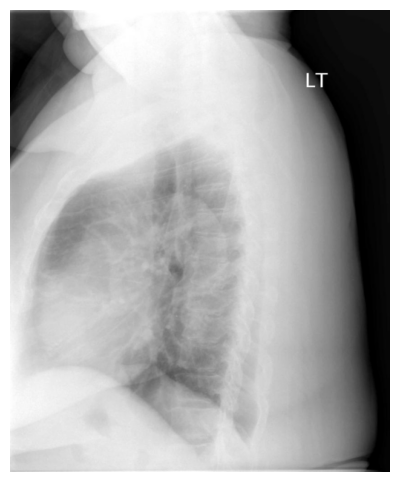

Generated report (beam):
 Findings: the cardiomediastinal silhouette is within normal limits for size and contour . the lungs are normally inflated without evidence of focal airspace disease pleural effusion or pneumothorax . osseous structures are within normal limits for patient age .
Impression: 1 . no acute radiographic cardiopulmonary process .


In [36]:
report_beam = trainer.robust_generate_radiology_report(
    image_input=["/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR1013_IM-0013-2001.png"],
    max_tokens=200,
    deterministic=True,
    beam_width=3,
    show_image=True # Set to True if you want to see the image
)

print("Generated report (beam):\n", report_beam)

In [ ]:
from torch.utils.data import ConcatDataset, DataLoader
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import single_meteor_score
from rouge_score import rouge_scorer
from tqdm import tqdm
import pandas as pd
def evaluate_dataloader_metrics_v2(dataloader, trainer, tokenizer, device, max_samples=None):
    results = []
    sample_count = 0
    smooth = SmoothingFunction()
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    for batch in tqdm(dataloader, desc="Evaluating dataset"):
        input_ids = batch['input_ids']
        image_paths_list = batch['image_paths']  # <- list of lists: one per sample

        for i in range(len(image_paths_list)):
            if max_samples and sample_count >= max_samples:
                break

            gt_input_ids = input_ids[i]
            if tokenizer.pad_token_id is not None:
                gt_input_ids = gt_input_ids[gt_input_ids != tokenizer.pad_token_id]
            reference_text = tokenizer.decode(gt_input_ids, skip_special_tokens=True)
            if not isinstance(reference_text, str) or len(reference_text.strip()) == 0:
                continue

            # --- Load all image views for this report ---
            pil_imgs = []
            for image_path in image_paths_list[i]:
                pil_img = Image.open(image_path).convert('RGB')
                pil_imgs.append(pil_img)
            # --- Generate report from all images for this study ---
            gen_report = trainer.robust_generate_radiology_report(
                pil_imgs,
                max_tokens=350,
                deterministic=True,
                beam_width=1,
            )
            
            
            # --- TOKENIZATION FOR METRICS ---
            ref_tokens = word_tokenize(reference_text)
            hyp_tokens = word_tokenize(gen_report)
            # BLEU scores for n = 1, 2, 3, 4
            bleu1 = sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth.method1)
            bleu2 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth.method1)
            bleu3 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth.method1)
            bleu4 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth.method1)

            # METEOR (pass as strings, NOT as lists)
            meteor = single_meteor_score(ref_tokens, hyp_tokens)


            # ROUGE-L
            rouge_l_score = rouge.score(reference_text, gen_report)['rougeL'].fmeasure

            results.append({
                'BLEU-1': bleu1,
                'BLEU-2': bleu2,
                'BLEU-3': bleu3,
                'BLEU-4': bleu4,
                'METEOR': meteor,
                'ROUGE-L': rouge_l_score
            })
            sample_count += 1
            if max_samples and sample_count >= max_samples:
                break
        if max_samples and sample_count >= max_samples:
            break

    results_df = pd.DataFrame(results)
    avg_scores = results_df.mean().to_dict()
    return results_df, avg_scores

# --- Example usage ---
results_df, avg_scores = evaluate_dataloader_metrics_v2(test_loader, trainer, tokenizer, train_config.device)
print(results_df)
print('Average Scores:', avg_scores)


In [37]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import random

def evaluate_on_val_samples(trainer, val_loader, tokenizer, num_samples=5):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    # Get a single batch from val_loader
    sample_batch = next(iter(val_loader))
    images_batch = sample_batch['images']  # (batch, max_views, 3, H, W)
    input_ids = sample_batch['input_ids']
    image_paths_batch = sample_batch['image_paths']  # list of lists

    total_samples = min(num_samples, images_batch.size(0))
    selected_indices = random.sample(range(images_batch.size(0)), total_samples)

    for idx in selected_indices:
        images_tensor_list = []
        pil_imgs = []
        # Visualize all views per sample, skip padded views if a view_mask exists
        if 'view_mask' in sample_batch:
            view_mask = sample_batch['view_mask'][idx]  # (max_views,)
        else:
            view_mask = [1] * images_batch.size(1)
        for view_idx in range(images_batch.size(1)):
            if view_mask[view_idx] == 0:
                continue  # skip padded images
            image_tensor = images_batch[idx, view_idx].cpu()
            image_disp = (image_tensor * std) + mean
            image_disp = torch.clamp(image_disp, 0, 1)
            pil_img = transforms.ToPILImage()(image_disp)
            pil_imgs.append(pil_img)
            images_tensor_list.append(image_tensor)

        # Plot all views in a row
        num_views = len(pil_imgs)
        plt.figure(figsize=(5 * num_views, 5))
        for i, img in enumerate(pil_imgs):
            plt.subplot(1, num_views, i+1)
            plt.imshow(img)
            plt.title(f"View {i+1}")
            plt.axis('off')
        plt.show()

        # Decode ground truth report
        ground_truth_ids = input_ids[idx]
        ground_truth_report = tokenizer.decode(ground_truth_ids, skip_special_tokens=True)

        # Generate report from all views using robust_generate_radiology_report
        generated_report = trainer.robust_generate_radiology_report(
            image_input=pil_imgs,
            max_tokens=350,
            deterministic=True,
            beam_width=3,
        )

        # Display reports
        print(f"\n--- Ground Truth Report ---\n{ground_truth_report.strip()}")
        print(f"\n--- Generated Report ---\n{generated_report.strip()}")
        print("-" * 80)


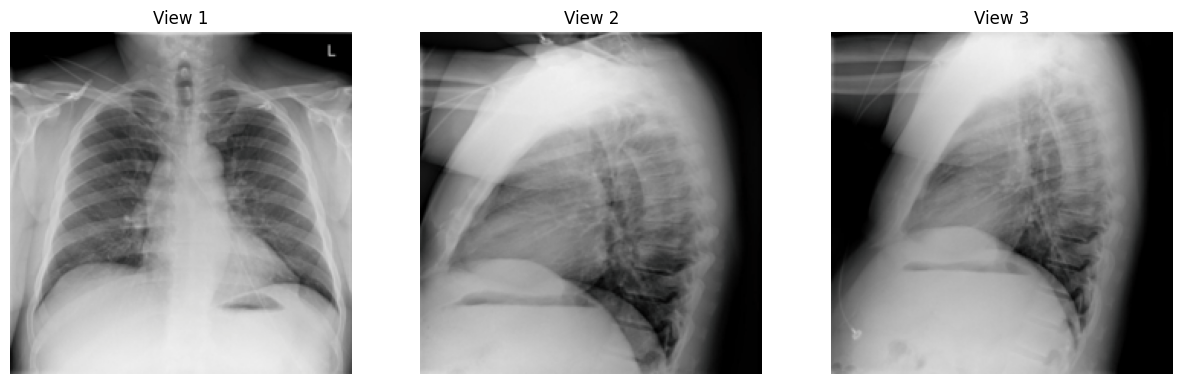


--- Ground Truth Report ---
three total images . heart size is normal . tortuous aorta including mildly ectatic appearing ascending aorta . no comparisons are available to evaluate stability . normal pulmonary vascularity . no focal infiltrates or pleural effusions . no pneumothorax .

--- Generated Report ---
Findings: the cardiomediastinal silhouette is within normal limits for size and contour . the lungs are normally inflated without evidence of focal airspace disease pleural effusion or pneumothorax . osseous structures are within normal limits for patient age .
Impression: 1 . no acute radiographic cardiopulmonary process .
--------------------------------------------------------------------------------


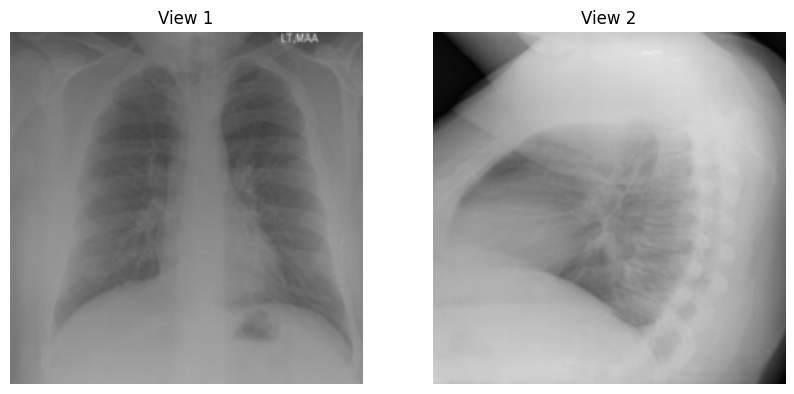


--- Ground Truth Report ---
mediastinal contours are normal . heart size is within normal limits . lungs are clear . there is no pneumothorax or large pleural effusion .  no acute cardiopulmonary abnormality .

--- Generated Report ---
Findings: the cardiomediastinal silhouette is within normal limits for size and contour . the lungs are normally inflated without evidence of focal airspace disease pleural effusion or pneumothorax . osseous structures are within normal limits for patient age .
Impression: 1 . no acute radiographic cardiopulmonary process .
--------------------------------------------------------------------------------


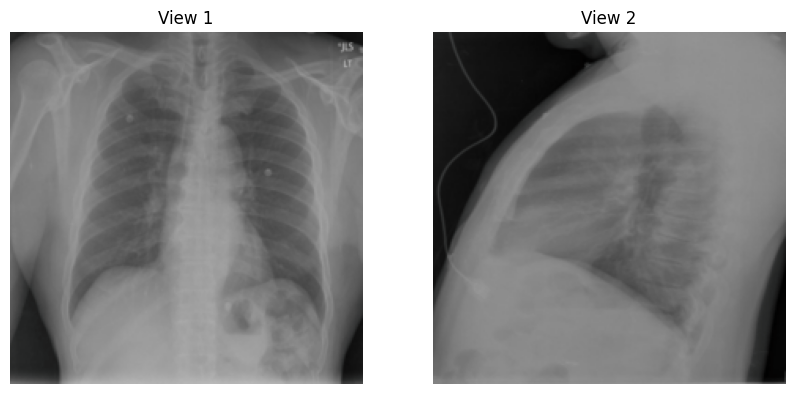


--- Ground Truth Report ---
cardiomediastinal silhouette demonstrates normal heart size with tortuosity and atherosclerosis of the thoracic aorta . no focal consolidation pneumothorax or pleural effusion . no acute bony abnormality identified . multilevel degenerative disc disease of the thoracic spine noted .  no acute cardiopulmonary abnormality .

--- Generated Report ---
Findings: the cardiomediastinal silhouette is within normal limits for size and contour . the lungs are normally inflated without evidence of focal airspace disease pleural effusion or pneumothorax . osseous structures are within normal limits for patient age .
Impression: 1 . no acute radiographic cardiopulmonary process .
--------------------------------------------------------------------------------


In [39]:
evaluate_on_val_samples(trainer, test_loader, tokenizer, num_samples=3)

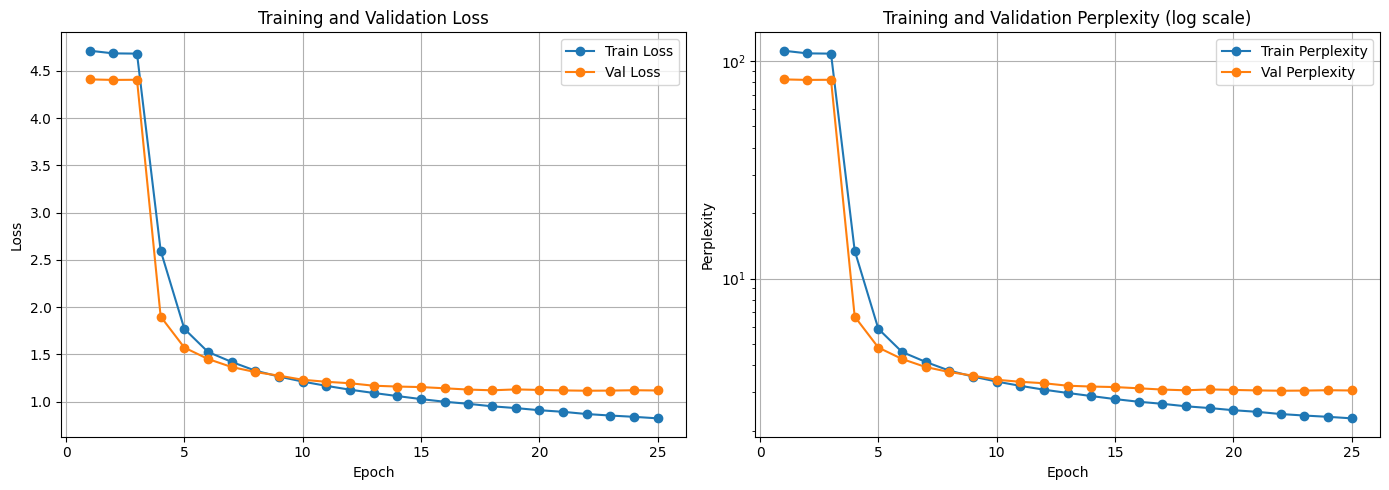

In [38]:
trainer.plot_loss_and_perplexity()